In [11]:
import torch
import torch.nn as nn
import numpy as np
import pandas as pd
import sys
sys.path.append('..')
import d2lzh_pytorch as d2l

In [2]:
train_file = '../data/kaggle_house/train.csv'
test_file = '../data/kaggle_house/test.csv'
train_data =pd.read_csv(train_file)
test_data = pd.read_csv(test_file)
n_train = train_data.shape[0]
n_test = test_data.shape[0]
print(train_data.shape)
print(test_data.shape)

(1460, 81)
(1459, 80)


In [3]:
train_features, test_features = train_data.iloc[:, 1:-1], test_data.iloc[:, 1:]
train_labels = train_data.iloc[:, -1]
all_features = pd.concat((train_features, test_features))

In [4]:
def clean_data(features):
    numeric_features = features.dtypes[features.dtypes != 'object'].index
    features[numeric_features] = features[numeric_features].apply(
        lambda x: (x - x.mean()) / x.std())
    features = features.fillna(0)
    
    features = pd.get_dummies(features, dummy_na=True)
    return features

In [5]:
all_features = clean_data(all_features)
train_features, test_features = all_features.iloc[:n_train, :], all_features.iloc[n_train:, :]
print(all_features.shape)

(2919, 354)


In [6]:
train_features = torch.tensor(train_features.values, dtype=torch.float)
train_labels = torch.tensor(train_labels.values, dtype=torch.float).view(-1, 1)
test_features = torch.tensor(test_features.values, dtype=torch.float)

In [10]:
loss = nn.MSELoss()

def get_net(num_features):
    net = nn.Linear(num_features, 1)
    for param in net.parameters():
        nn.init.normal_(param, mean=0, std=0.01)
    return net

def log_rmse(out, y):
    log_out = out.log()
    log_y = y.log()
    return loss(log_out, log_y)

In [8]:
def train(net, train_features, train_labels, test_features, test_labels,
          num_epochs, leaing_rate, weight_decay, batch_size):
    train_ls, test_ls = [], []
    train_dataset = torch.utils.data.TensorDataset(train_features, train_labels)
    train_iter = torch.utils.data.DataLoader(train_dataset, batch_size, shuffle=True)
    optimizer = torch.optim.Adam(params=net.parameters(), lr=leaing_rate, weight_decay=weight_decay)
    
    net = net.float()
    
    for _ in range(num_epochs):
        for X, y in train_iter:
            out = net(X.float())
            l = loss(out, y.float())
            optimizer.zero_grad()
            l.backward()
            optimizer.step()
        train_ls.append(log_rmse(net(train_features), train_labels))
        if test_labels is not None:
            test_ls.append(log_rmse(net(test_features), test_labels))
    return train_ls, test_ls                           

In [9]:
def get_k_fold_data(k, i, features, labels):
    assert k > 1
    assert i <= k
    fold_size = features.shape[0] // k
    features_train, labels_train = None, None
    for j in range(k):
        idx = slice(j * fold_size, (j+1) * fold_size)
        features_part, labels_part = features[idx], labels[idx]
        if j == i:
            features_valid, label_valid = features_part, labels_part
        elif features_train is None:
            features_train, labels_train = features_part, labels_part
        else:
            features_train = torch.cat((features_train, features_part), dim=0)
            labels_train = torch.cat((labels_train, labels_part), dim=0)
    return features_train, labels_train, features_valid, label_valid

In [24]:
def k_fold(k, X, y, num_epochs, learning_rate, weight_decay, batch_size):
    train_ls_sum, valid_l_sum = 0, 0
    for i in range(k):
        data = get_k_fold_data(k, i, X, y)
        net = get_net(X.shape[1])
        train_ls, test_ls = train(net, *data, num_epochs, learning_rate, weight_decay, batch_size)
        train_ls_sum += train_ls[-1]
        valid_l_sum += test_ls[-1]
        if i == 0:
            d2l.semilogy(range(1, num_epochs + 1), train_ls, 'epochs', 'rmse',
                         range(1, num_epochs + 1), test_ls,
                         ['train', 'valid'])
        print('fold %d, train rmse %f, valid rmse %f' % (i, train_ls[-1], test_ls[-1]))
    return train_ls_sum / k, valid_l_sum / k

fold 0, train rmse 0.016242, valid rmse 0.021789
fold 1, train rmse 0.015362, valid rmse 0.021831
fold 2, train rmse 0.015334, valid rmse 0.021521
fold 3, train rmse 0.016552, valid rmse 0.017936
fold 4, train rmse 0.014546, valid rmse 0.026750
5-fold validation: avg train rmse 0.015607, avg valid rmse 0.021965


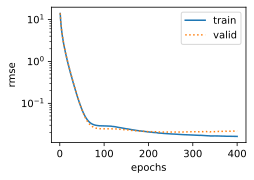

In [43]:
k, num_epochs, lr, weight_decay, batch_size = 5, 400, 5, 0, 64
train_ls, valid_ls = k_fold(k, train_features, train_labels, num_epochs, lr, weight_decay, batch_size)
print('%d-fold validation: avg train rmse %f, avg valid rmse %f' % (k, train_ls, valid_ls))

In [27]:
def train_and_pred(train_features, train_labels, test_features, test_data, num_epochs, lr, weight_decay, batch_size):
    net = get_net(train_features.shape[1])
    train_ls, _ = train(net, train_features, train_labels, None, None, num_epochs, lr, weight_decay, batch_size)
    d2l.semilogy(range(1, num_epochs + 1), train_ls, 'epochs', 'rmse')
    print('train rmse %f' % train_ls[-1])
    preds = net(test_features).detach().numpy()
    test_data['SalePrice'] = pd.Series(preds.reshape(1, -1)[0])
    submission = pd.concat([test_data['Id'], test_data['SalePrice']], axis=1)
    submission.to_csv('./submission.csv', index=False)

In [28]:
net = get_net(train_features.shape[1])
train_ls, _ = train(net, train_features, train_labels, None, None, num_epochs, lr, weight_decay, batch_size)
preds = net(test_features).detach().numpy()

In [31]:
preds.reshape(1, -1)[0].shape

(1459,)

train rmse 0.015645


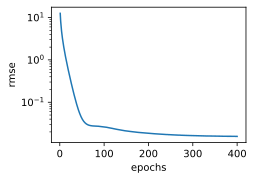

In [44]:
train_and_pred(train_features, train_labels, test_features, test_data, num_epochs, lr, weight_decay, batch_size)